# Actors Marriage and Divorce according to Wikipedia

In [ ]:
! pip install ndjson

In [284]:
from pandas.io.json import json_normalize
import pandas as pd
import ndjson
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

#### Load data and flatten nested column

In [285]:
path = os.getcwd() + '\\wiki\\cleaned_actors.ndjson'
with open(path) as file:
    data = ndjson.load(file)
data = [dict(zip(['name','birth_day','spouse','label','gender','nationality','awards'],x)) for x in data]
all_actors=json_normalize(data)
all_actors['occupation']='actors'
all_actors['awards_count'] = all_actors.awards.str.len()
all_actors=all_actors[['name','birth_day','birth_day.year','birth_day.month','birth_day.date','spouse','label','gender','nationality','awards','awards_count']]
all_actors.head()

,name,birth_day,birth_day.year,birth_day.month,birth_day.date,spouse,label,gender,nationality,awards,awards_count
0,Amitabh Bachchan,NaN,1942,10,11,"[{'spouse': 'Jaya Bachchan|Jaya Bhaduri', 'fro...",nested,male,[Indian],[Category:Best Actor National Film Award winne...,2
1,Aaliyah,NaN,1979,1,16,"[{'spouse': 'R. Kelly', 'from': 'August 31, 19...",nested,female,[American],[],0
2,Anthony Hopkins,NaN,1937,12,31,"[{'spouse': 'Petronella Barker (actress, born ...",nested,male,[Welsh],"[Category:Best Actor BAFTA Award winners, Cate...",8
3,Ardal O'Hanlon,NaN,1965,10,8,[Melanie O'Hanlon],not_nested,male,[],[],0
4,Adam Carolla,NaN,1964,5,27,"[Lynette Paradise (2002–present), 2002–present]",not_nested,male,[American],[],0


#### Add spouse count for actors with nested spouse info

In [286]:
nested=all_actors[all_actors['label']=='nested'][['name', 'birth_day', 'birth_day.year', 'birth_day.month',
       'birth_day.date', 'label', 'gender',
       'nationality', 'awards', 'awards_count', 'spouse']]
nested['spouse_count'] = nested.spouse.str.len()

#### Clean records with unnested spouse info

In [287]:
unnested = all_actors[all_actors['label']=='not_nested']
def clean_this_mess(list):
    if len(list)==0:
        return []
    elif len(list)==2:
        return [list[0].strip('< br / >').strip('< br/ >').strip('< br >')]
    else:
        return list[0].split(' < br')
unnested=pd.concat([unnested.drop(['spouse'], axis=1), unnested['spouse'].apply(lambda x: clean_this_mess(x))], axis=1)
unnested['spouse_count'] = unnested.spouse.str.len()

#### How many times do actors get married?

In [337]:
combined_actors = nested.append(unnested)
from termcolor import colored
from dateutil.parser import parse
def parse_year(x):
    try:
        return parse(x,fuzzy=True).year
    except:
        return None
combined_actors['age'] = combined_actors['birth_day.year'].apply(lambda x: 2019-parse_year(x) if parse_year(x) is not None else 999)
adult_actors = combined_actors[combined_actors['age']>=18]
never_married = adult_actors[adult_actors['spouse_count']==0].name.count()
actor_count = combined_actors.name.count()
adult_count = adult_actors.name.count()
total_marriages = adult_actors.spouse_count.sum()
median_spouse_count = combined_actors.spouse_count.median()
print('%d actors\' information was collected from the "21-century Actors/Actresses" categories on Wikipedia. Assuming those with age unknown are 18 or above, '
      'that is %d adult actors, among whom %d (or %d%%) have never been married, while the rest have got married a total of %d times. We read a lot about Hollywood weddings in taloids, '
      'but the median number of times adult actors get married turns out to be - %d!' %(actor_count, adult_count, never_married, never_married/adult_count *100, total_marriages, median_spouse_count))

23953 actors' information was collected from the "21-century Actors/Actresses" categories on Wikipedia. Assuming those with age unknown are 18 or above, that is 23775 adult actors, among whom 14881 (or 62%) have never been married, while the rest have got married a total of 11138 times. We read a lot about Hollywood weddings in taloids, but the median number of times adult actors get married turns out to be - 0!


#### Do more successful actors tend to marry more times?

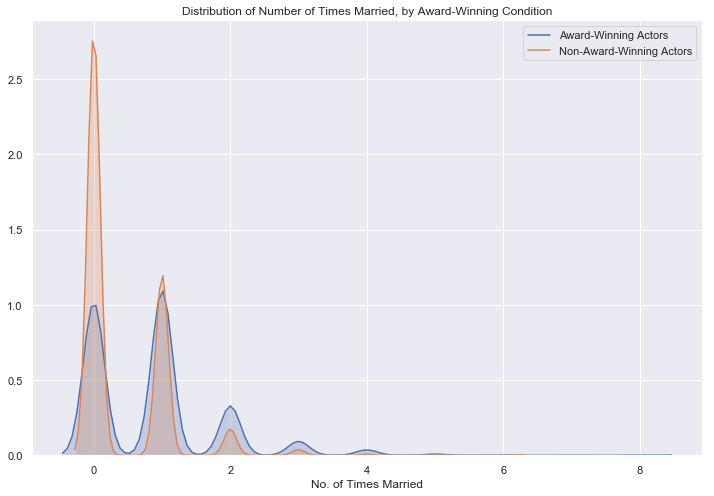

In [289]:
plt.figure(figsize=(12,8))
sns.kdeplot(data=adult_actors[adult_actors['awards_count'] > 0]['spouse_count'],label='Award-Winning Actors', shade=True)
sns.kdeplot(data=adult_actors[adult_actors['awards_count'] == 0]['spouse_count'],label='Non-Award-Winning Actors', shade=True)

plt.xlabel('No. of Times Married')
plt.title('Distribution of Number of Times Married, by Award-Winning Condition') #How many roads must a man/woman walk down
plt.legend()

C:\Users\efan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'More Successful, More Marriages?')

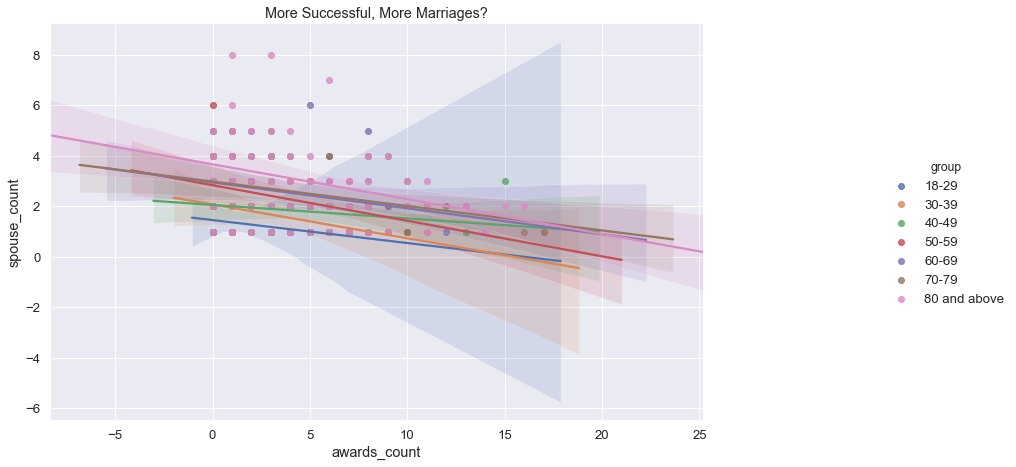

In [330]:
actors_w_age = adult_actors[adult_actors['age'] != 999]
actors_w_age['group']=pd.cut(actors_w_age['age'], bins=[18, 30, 40, 50, 60, 70, 80,200], include_lowest=True, right=False, labels=['18-29', '30-39', '40-49','50-59','60-69','70-79','80 and above'])
marriage_vs_spouse=pd.DataFrame({'count' : actors_w_age.groupby( [ 'group', 'awards_count','spouse_count']).size()}).reset_index()
marriage_vs_spouse=marriage_vs_spouse[marriage_vs_spouse['spouse_count'] >0]
sns.set(font_scale=1.2)
sns.lmplot(x='awards_count', y='spouse_count', data=marriage_vs_spouse, fit_reg=True, hue='group')#,scatter_kws={"s": actors_w_age.name.count()/100}
plt.gcf().set_size_inches(16, 7)
plt.title("More Successful, More Marriages?")

#### Actors Married The Most Times

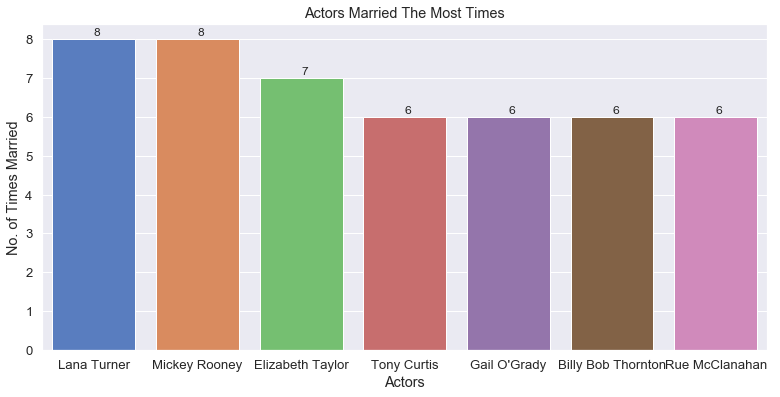

In [332]:
sorted_by_spouse_count = combined_actors.sort_values(by=['spouse_count'],ascending=False)
actors_married_most = sorted_by_spouse_count[sorted_by_spouse_count['spouse_count']>5]
plt.figure(figsize=(13,6))
sns.set(font_scale=1.2)
sns.barplot(x=actors_married_most['name'], y=actors_married_most['spouse_count'],palette='muted')#Blues_d
plt.xlabel('Actors')
plt.ylabel('No. of Times Married')
plt.title("Actors Married The Most Times")
actors_married_most['spouse_count']
for i in range(7):
    plt.text(x = i , y = actors_married_most['spouse_count'].iloc[i]+0.1, s = str(actors_married_most['spouse_count'].iloc[i]), size = 12)
plt.show()

#### Stack nested marriage records and flatten dictionaries inside

In [292]:
target_col = 'spouse'
nested_marriages1 = pd.DataFrame({
      col:np.repeat(nested[col].values, nested[target_col].str.len())
      for col in nested.columns.drop(target_col)}
    ).assign(**{target_col:np.concatenate(nested[target_col].values)})[nested.columns]
nested_marriages2=pd.concat([nested_marriages1.drop(['spouse','awards','birth_day','birth_day.month','birth_day.date'], axis=1), nested_marriages1['spouse'].apply(pd.Series)], axis=1)

#### Parse year and "Reason" for nested marriage records

In [293]:
def parse_reason(x):
    if x is np.nan:
        return 'still married'
    elif 'div' in x:
        return 'divorce'
    elif 'dea' in x or 'wid' in x or 'die' in x or 'dec' in x or 'omi' in x or '=d' in x:
        return 'death'
    elif 'ann' in x:
        return 'annulment'
    else:
        'unknown'

In [294]:
nested_marriages3=pd.concat([nested_marriages2.drop(['from'], axis=1), nested_marriages2['from'].apply(lambda x: parse_year(x))], axis=1)
nested_marriages3['to2']=nested_marriages3['to'].apply(lambda x: parse_year(x))
nested_marriages3=pd.concat([nested_marriages3.drop(['birth_day.year'], axis=1), nested_marriages3['birth_day.year'].apply(lambda x: parse_year(x))], axis=1)
nested_marriages3=pd.concat([nested_marriages3.drop(['reason'], axis=1), nested_marriages3['reason'].apply(lambda x: parse_reason(x))], axis=1)
nested_marriages3['reason'][nested_marriages3.to.str.contains('omit',case=False, na=False)] = 'death' #case insensitive and ignore na
nested_marriages3['reason'][(nested_marriages3['to'].notnull()) & (nested_marriages3['reason']=='still married') & (nested_marriages3['to']!='')] = 'unknown'
nested_marriages=nested_marriages3.drop(['to'],axis=1)
nested_marriages.columns=['name', 'label', 'gender', 'nationality', 'awards_count', 'spouse_count', 'spouse', 'from', 'to', 'birth_year', 'reason']

C:\Users\efan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\efan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Clean unnested marriage records

In [295]:
target_col = 'spouse'
unnested_marriages1 = pd.DataFrame({
      col:np.repeat(unnested[col].values, unnested[target_col].str.len())
      for col in unnested.columns.drop(target_col)}
    ).assign(**{target_col:np.concatenate(unnested[target_col].values)})[unnested.columns]
def trim_before_name(s):
    try:
        for i,x in enumerate(s):
            if x.isalpha():         
                pos = i
                break
        return s[pos:]
    except:
        return s
def find_reason(x):
    if x is np.nan:
        return 'unknown'
    elif 'div' in x or 'Div' in x:
        return 'divorce'
    elif 'death' in x or 'widow' in x or 'decease' in x or 'demise' in x:
        return 'death'
    elif 'annull' in x:
        return 'annulment'
    elif 'sepa' in x or 'Sepa' in x:
        return 'separation'
    elif 'present' in x:
        return 'still married'
    elif len(re.findall('(?:19|20)\d{2}',x))<=1: #check the number of year-like sub-strings
        return 'still married'
    else:
        return 'unknown'
unnested_marriages2=pd.concat([unnested_marriages1.drop(['spouse'], axis=1), unnested_marriages1['spouse'].apply(lambda x: trim_before_name(x))], axis=1)
unnested_marriages2['reason']=unnested_marriages2['spouse'].apply(lambda x: find_reason(x))
unnested_marriages2['spouse_name']=unnested_marriages2['spouse'].apply(lambda x: x.split('(',1)[0].split('<',1)[0] if '(' in x else x.split('<',1)[0])
unnested_marriages2['from']=unnested_marriages2['spouse'].apply(lambda x: parse_year(re.findall('(?:19|20)\d{2}',x)[0]) if len(re.findall('(?:19|20)\d{2}',x))>=1 else np.nan)
unnested_marriages2['to']=unnested_marriages2['spouse'].apply(lambda x: parse_year(re.findall('(?:19|20)\d{2}',x)[1]) if len(re.findall('(?:19|20)\d{2}',x))>=2 else np.nan)
unnested_marriages3=unnested_marriages2.drop(['spouse','awards','birth_day','birth_day.month','birth_day.date'],axis=1)
unnested_marriages4=pd.concat([unnested_marriages3.drop(['birth_day.year'], axis=1), unnested_marriages3['birth_day.year'].apply(lambda x: parse_year(x))], axis=1)
unnested_marriages=unnested_marriages4[['name', 'label', 'gender', 'nationality', 'awards_count', 'spouse_count', 'spouse_name', 'from', 'to', 'birth_day.year', 'reason']]
unnested_marriages.columns=['name', 'label', 'gender', 'nationality', 'awards_count', 'spouse_count', 'spouse', 'from', 'to', 'birth_year', 'reason']

#### How many actors' marriages have ended in divorce and how long did their marriages last?

In [361]:
still_married=actor_marriages[actor_marriages['reason'] =='still married'].name.count()/actor_marriages[actor_marriages['reason']!='unknown'].name.count() * 100
crude_divorce_rate=actor_marriages[actor_marriages['reason'] =='divorce'].name.count()/all_actors.name.count() * 100
divorce_to_marriage_ratio=actor_marriages[actor_marriages['reason'] =='divorce'].name.count()/actor_marriages.name.count() * 100
ended_marriages = actor_marriages[(actor_marriages['reason']=='divorce') | (actor_marriages['reason']=='death') | (actor_marriages['reason']=='annulment') | (actor_marriages['reason']=='unknown')].name.count()
end_with_divorce=actor_marriages[actor_marriages['reason'] =='divorce'].name.count()/ended_marriages * 100
end_by_death=actor_marriages[actor_marriages['reason'] =='death'].name.count()/ended_marriages * 100
median_length=actor_marriages.length.median()
ten_year=actor_marriages[(actor_marriages['from']<=2009)&(actor_marriages['reason']=='still married')].name.count()/actor_marriages[actor_marriages['from']<=2009].name.count() * 100
twenty_year=actor_marriages[(actor_marriages['from']<=1999)&(actor_marriages['reason']=='still married')].name.count()/actor_marriages[actor_marriages['from']<=1999].name.count() * 100
print('Out of all actor marriages, %d%% of the couples are still married. The Crude Divorce Rate (number of divorces out of the population) of actors is %d%%, while the Divorce-to-Marriage '
      'Ratio (total number of divorce out of total number of marriages) is %d%%. \n\nAmong marriages that have ended, Divorce (%d%%) is the No.1 reason, followed by Death (%d%%). The median '
      'length of actors\' marriages is %d years - proving some truth to the "Seven-year Itch". \n\nAlthough if we look at all the couples that married at least a decade ago, %d%% of them have '
      'hit the ten-year mark. And %d%% couples who married at least twenty years ago are still married.' %(still_married, crude_divorce_rate,divorce_to_marriage_ratio, end_with_divorce, end_by_death,median_length, ten_year, twenty_year))

Out of all actor marriages, 64% of the couples are still married. The Crude Divorce Rate (number of divorces out of the population) of actors is 11%, while the Divorce-to-Marriage Ratio (total number of divorce out of total number of marriages) is 25%. 

Among marriages that have ended, Divorce (67%) is the No.1 reason, followed by Death (13%). The median length of actors' marriages is 7 years - proving some truth to the "Seven-year Itch". 

Although if we look at all the couples that married at least a decade ago, 41% of them have hit the ten-year mark. And 31% couples who married at least twenty years ago are still married.


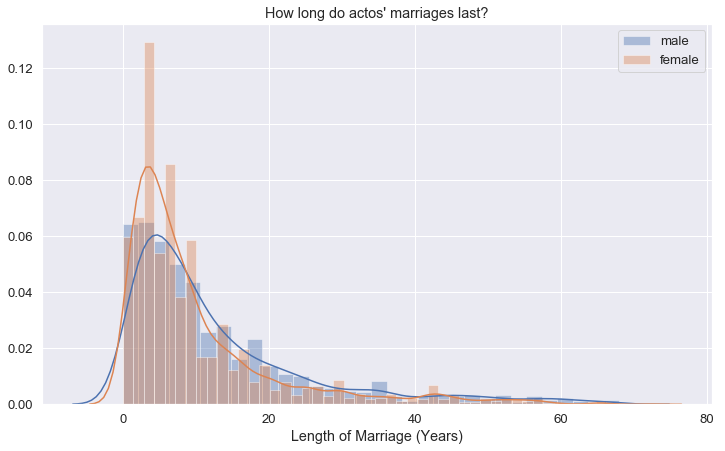

In [359]:
actor_marriages = nested_marriages.append(unnested_marriages)
actor_marriages['length']=actor_marriages['to']-actor_marriages['from']
sns.set(font_scale=1.2)
sns.distplot(a=actor_marriages['length'][(actor_marriages['gender']=='male') & (actor_marriages['length'].notnull())].astype(int), label="male", kde=True)
sns.distplot(a=actor_marriages['length'][(actor_marriages['gender']=='female') & (actor_marriages['length'].notnull())].astype(int), label="female", kde=True)
plt.gcf().set_size_inches(12, 7)
plt.xlabel('Length of Marriage (Years)')
plt.title('How long do actos\' marriages last?')
plt.legend()

Text(0.5, 1.0, 'Length of Marriage Across Generations (Excluding On-going Marriages)')

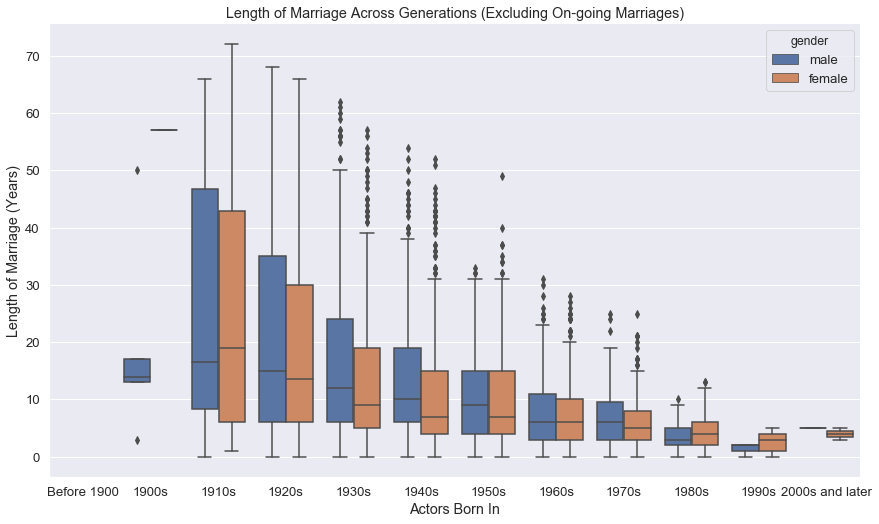

In [363]:
actor_marriages['age_group']=pd.cut(actor_marriages['birth_year'], bins=[1869, 1900, 1910, 1920, 1930, 1940, 1950,1960,1970,1980,1990,2000,2010], include_lowest=True, right=False, labels=['Before 1900','1900s', '1910s', '1920s','1930s','1940s','1950s','1960s','1970s','1980s','1990s','2000s and later'])
sns.set_style('ticks')
sns.set(font_scale=1.2)
sns.catplot(x='age_group', y='length', hue='gender', kind='box', data=actor_marriages, legend_out=False)
plt.gcf().set_size_inches(16, 8)
plt.xlabel('Actors Born In')
plt.ylabel('Length of Marriage (Years)')
plt.title('Length of Marriage Across Generations (Excluding On-going Marriages)')

### Below is still in progress

#### Median Age when Actors and Actresses Encounter Their First Marriage and First Divorce, and How it Varies by Country

#### Do Actors Marry Other Actors?

#### How Does Actors' Divorce Rate Compare to Politicians and Sports Stars?

In [264]:
actor_marriages['age_married']=actor_marriages['from']-actor_marriages['birth_year']
actor_marriages['age_divorced']=actor_marriages['to']-actor_marriages['birth_year']

actor_marriages.head()

,name,label,gender,nationality,awards_count,spouse_count,spouse,from,to,birth_year,reason,length,age_group,age_married,age_divorced
0,Amitabh Bachchan,nested,male,[Indian],2,1,Jaya Bachchan|Jaya Bhaduri,1973.0,NaN,1942.0,still married,NaN,1940s,31.0,NaN
1,Aaliyah,nested,female,[American],0,1,R. Kelly,1994.0,1995.0,1979.0,annulment,1.0,1970s,15.0,16.0
2,Anthony Hopkins,nested,male,[Welsh],8,3,"Petronella Barker (actress, born 1942)|Petrone...",1966.0,1972.0,1937.0,divorce,6.0,1930s,29.0,35.0
3,Anthony Hopkins,nested,male,[Welsh],8,3,Jennifer Lynton,1973.0,2002.0,1937.0,divorce,29.0,1930s,36.0,65.0
4,Anthony Hopkins,nested,male,[Welsh],8,3,Stella Arroyave,2003.0,NaN,1937.0,still married,NaN,1930s,66.0,NaN


In [314]:
actor_marriages.groupby(['reason']).length.count()

reason
annulment          35
death             509
divorce          2602
separation          5
still married       6
unknown           759
Name: length, dtype: int64

In [213]:
combined_actors[combined_actors['age']==999]

,name,birth_day,birth_day.year,birth_day.month,birth_day.date,label,gender,nationality,awards,awards_count,spouse,spouse_count,age
1716,Kate Fahy,unknown,NaN,NaN,NaN,nested,female,[English],[],0,"[{'spouse': 'Jonathan Pryce', 'from': '2015'}]",1,999
2090,Christopher Britton (actor),unknown,NaN,NaN,NaN,nested,male,[Canadian],[],0,"[{'spouse': 'Claudette Jaiko', 'from': '1980',...",2,999
3364,Mare Winningham,NaN,19591,5,16,nested,female,[American],"[Category:Independent Spirit Award winners, Ca...",2,"[{'spouse': 'A Martinez', 'from': '1981', 'to'...",3,999
4888,Tony Yazbeck,unknown,NaN,NaN,NaN,nested,male,[American],[],0,"[{'spouse': 'Katie Huff', 'from': '2014'}]",1,999
4937,Lulu Pinkus,unknown,NaN,NaN,NaN,nested,female,[Australian],[],0,"[{'spouse': 'Yahoo Serious', 'from': '1989', '...",1,999
5533,Eliza Clark (writer),unknown,NaN,NaN,NaN,nested,female,[American],[],0,"[{'spouse': 'Zack Whedon', 'from': '2012', 'to...",1,999
6970,Shakib Khan,unknown,NaN,NaN,NaN,nested,male,[Bangladeshi],[],0,"[{'spouse': 'Apu Biswas', 'from': '2008', 'to'...",1,999
6974,Swwapnil Joshi,unknown,NaN,NaN,NaN,nested,male,[Indian],[],0,"[{'spouse': 'Aparna Joshi', 'from': '2005', 't...",2,999
7190,Saiju Kurup,unknown,NaN,NaN,NaN,nested,male,[Indian],[],0,"[{'spouse': 'Anupama', 'from': '2005'}]",1,999
7332,Jake Lacy,unknown,NaN,NaN,NaN,nested,male,[American],[],0,"[{'spouse': 'Lauren Deleo', 'from': '2015'}]",1,999


In [243]:
# check specific record
all_actors[all_actors['name']=='John Cleese']

,name,birth_day,birth_day.year,birth_day.month,birth_day.date,spouse,label,gender,nationality,awards,awards_count
43,John Cleese,NaN,1939,10,27,"[{'spouse': 'Connie Booth', 'from': '1968', 't...",nested,male,[English],"[Category:BAFTA winners (people), Category:Bes...",3
